_Lambda School Data Science — Practicing & Understanding Predictive Modeling_

# Review & Regularization

## Start with example solution for yesterday's assignment

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [0]:
# We'll modify a project from Python Data Science Handbook by Jake VanderPlas
# https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic
    
# Predicting Bicycle Traffic

# As an example, let's take a look at whether we can predict the number of 
# bicycle trips across Seattle's Fremont Bridge based on weather, season, 
# and other factors.

# We will join the bike data with another dataset, and try to determine the 
# extent to which weather and seasonal factors—temperature, precipitation, 
# and daylight hours—affect the volume of bicycle traffic through this corridor. 
# Fortunately, the NOAA makes available their daily weather station data 
# (I used station ID USW00024233) and we can easily use Pandas to join 
# the two data sources.

def load(): 
    fremont_bridge = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
    
    bicycle_weather = 'https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv'

    counts = pd.read_csv(fremont_bridge, index_col='Date', parse_dates=True, 
                         infer_datetime_format=True)

    weather = pd.read_csv(bicycle_weather, index_col='DATE', parse_dates=True, 
                          infer_datetime_format=True)

    daily = counts.resample('d').sum()
    daily['Total'] = daily.sum(axis=1)
    daily = daily[['Total']] # remove other columns

    weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
    daily = daily.join(weather[weather_columns], how='inner')
    
    # Make a feature for yesterday's total
    daily['Total_yesterday'] = daily.Total.shift(1)
    daily = daily.drop(index=daily.index[0])
    
    return daily

In [0]:
def split(daily):
    # Hold out an "out-of-time" test set, from the last 100 days of data
    
    train = daily[:-100]
    test = daily[-100:]
    
    X_train = train.drop(columns='Total')
    y_train = train.Total

    X_test  = test.drop(columns='Total')
    y_test  = test.Total
    ""
    return X_train, X_test, y_train, y_test

In [0]:
def jake_wrangle(X):  
    X = X.copy()

    # patterns of use generally vary from day to day; 
    # let's add binary columns that indicate the day of the week:
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i, day in enumerate(days):
        X[day] = (X.index.dayofweek == i).astype(float)


    # we might expect riders to behave differently on holidays; 
    # let's add an indicator of this as well:
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays('2012', '2016')
    X = X.join(pd.Series(1, index=holidays, name='holiday'))
    X['holiday'].fillna(0, inplace=True)


    # We also might suspect that the hours of daylight would affect 
    # how many people ride; let's use the standard astronomical calculation 
    # to add this information:
    def hours_of_daylight(date, axis=23.44, latitude=47.61):
        """Compute the hours of daylight for the given date"""
        days = (date - pd.datetime(2000, 12, 21)).days
        m = (1. - np.tan(np.radians(latitude))
             * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
        return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

    X['daylight_hrs'] = list(map(hours_of_daylight, X.index))


    # temperatures are in 1/10 deg C; convert to C
    X['TMIN'] /= 10
    X['TMAX'] /= 10

    # We can also calcuate the average temperature.
    X['Temp (C)'] = 0.5 * (X['TMIN'] + X['TMAX'])


    # precip is in 1/10 mm; convert to inches
    X['PRCP'] /= 254

    # In addition to the inches of precipitation, let's add a flag that 
    # indicates whether a day is dry (has zero precipitation):
    X['dry day'] = (X['PRCP'] == 0).astype(int)


    # Let's add a counter that increases from day 1, and measures how many 
    # years have passed. This will let us measure any observed annual increase 
    # or decrease in daily crossings:
    X['annual'] = (X.index - X.index[0]).days / 365.

    return X

In [0]:
# Download and join data into a dataframe
data = load()

#### `SNOW` and `AWND` have minimums of `-9999` ...

In [8]:
data.describe(include='number')

,Total,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday
count,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000
mean,2632.449671,29.350894,-37.496707,0.098777,166.863594,84.472248,22.338664,2633.056444
std,1252.864020,65.813053,612.512583,2.570041,74.779734,50.916006,307.984292,1253.138245
min,98.000000,0.000000,-9999.000000,0.000000,-16.000000,-71.000000,-9999.000000,98.000000
25%,1806.000000,0.000000,0.000000,0.000000,111.000000,44.000000,22.000000,1806.000000
50%,2435.000000,0.000000,0.000000,0.000000,150.000000,83.000000,29.000000,2435.000000
75%,3574.500000,26.500000,0.000000,0.000000,222.000000,128.000000,40.000000,3574.500000
max,6088.000000,559.000000,74.000000,80.000000,356.000000,183.000000,95.000000,6088.000000


### Clean data and engineer features

In [0]:
def wrangle(X):
    X = X.copy()
    X = X.replace(-9999, 0)
    X = jake_wrangle(X)
    
    # DS1 DH
    X['PRCP_yesterday'] = X.PRCP.shift(1).fillna(X.PRCP.mean())
    X['Windchill'] = (((X['Temp (C)'] * (9/5) + 32) * .6215) + 34.74) - (35.75 * (X['AWND']** .16)) + (.4275 * (X['Temp (C)'])) * (X['AWND'] ** .16)
    X['Rl_Cold'] = (((X['Temp (C)'] * (9/5) + 32) - X['Windchill']) -32) * (5/9)
    X['TMIN_squared'] = X['TMIN'] **2
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i, month in enumerate(months):
        X[month] = (X.index.month == i+1).astype(float)
    
    # DS3 JD
    X['light_rain'] = (X['PRCP'] > 0) & (X['PRCP'] < 0.10)
    X['moderate_rain'] = (X['PRCP'] >= 0.1) & (X['PRCP'] < 0.30)
    X['heavy_rain'] = (X['PRCP'] >= 0.30)
    X['weekend_day'] = (X['Sat'] == 1) | (X['Sun'] == 1)

    return X

In [0]:
# Split data into train and test
X_train, X_test, y_train, y_test = split(data)

# Do the same wrangling to X_train and X_test
X_train = wrangle(X_train)
X_test  = wrangle(X_test)

### RandomizedSearchCV review / SPRINT CHALLENGE PRACTICE
- https://twitter.com/jakevdp/status/648593367786323968
- https://www.google.com/search?q=site%3Ascikit-learn.org+RandomizedSearchCV
  - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
  - https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html
- https://www.google.com/search?q=XGBRegressor
  - https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://www.google.com/search?q=xgboost+parameter+tuning
  - https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
- https://nbviewer.jupyter.org/github/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from scipy.stats import randint

param_distributions = {
    'n_estimators': randint(50, 500),
    'max_depth' : randint(1,5),
}

search = RandomizedSearchCV(
    estimator=XGBRegressor(n_jobs=-1, random_state=42),
    param_distributions=param_distributions,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=3,
    verbose=10,
    return_train_score=True
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f94fbd30ef0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f94f083eb70>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [17]:
print('Mean Absolute Error with cross-validation: ',-search.best_score_)
print(f'Predictions off by {int(-search.best_score_)} biciclysts per day, on average')

Mean Absolute Error with cross-validation:  264.7045168218088
Predictions off by 264 biciclysts per day, on average


In [18]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
2,0.267372,0.010108,0.005686,0.000049,4,116,"{'max_depth': 4, 'n_estimators': 116}",-240.762841,-299.968447,-253.382262,-264.704517,25.462012,1,-107.886730,-102.237009,-106.014754,-105.379498,2.349822
48,0.284555,0.008173,0.005945,0.000143,2,228,"{'max_depth': 2, 'n_estimators': 228}",-240.611737,-303.666106,-255.172724,-266.483522,26.955692,2,-177.498514,-168.859841,-174.287745,-173.548700,3.565231
27,0.268284,0.018099,0.005758,0.000221,3,146,"{'max_depth': 3, 'n_estimators': 146}",-243.931550,-304.849715,-250.923036,-266.568100,27.219255,3,-143.213147,-138.635234,-144.371361,-142.073247,2.476600
37,0.266704,0.009938,0.005659,0.000136,3,145,"{'max_depth': 3, 'n_estimators': 145}",-243.833395,-305.139166,-250.984891,-266.652484,27.370355,4,-143.874601,-139.323232,-144.652624,-142.616819,2.350477
40,0.292126,0.004409,0.005998,0.000088,2,238,"{'max_depth': 2, 'n_estimators': 238}",-240.618443,-302.484011,-258.908181,-267.336878,25.950200,5,-175.251317,-166.169528,-172.448892,-171.289912,3.797117
26,0.218329,0.010971,0.005290,0.000140,3,122,"{'max_depth': 3, 'n_estimators': 122}",-243.309740,-304.413538,-254.310872,-267.344717,26.593600,6,-154.573488,-148.836114,-154.090917,-152.500173,2.598360
16,0.326613,0.004012,0.006436,0.000101,2,267,"{'max_depth': 2, 'n_estimators': 267}",-240.444091,-302.803964,-259.613981,-267.620679,26.080246,7,-169.646317,-160.380511,-166.519723,-165.515517,3.848819
43,0.373139,0.006403,0.006654,0.000178,2,300,"{'max_depth': 2, 'n_estimators': 300}",-242.071675,-303.927786,-258.340272,-268.113244,26.181136,8,-164.870262,-154.136365,-159.759961,-159.588863,4.383765
45,0.367194,0.012642,0.006570,0.000149,2,295,"{'max_depth': 2, 'n_estimators': 295}",-242.121339,-303.479447,-259.184690,-268.261825,25.858592,9,-165.616586,-154.677755,-160.831427,-160.375256,4.477393
39,0.406575,0.011126,0.007105,0.000256,4,188,"{'max_depth': 4, 'n_estimators': 188}",-251.782625,-302.306952,-251.341055,-268.476877,23.922154,10,-75.847807,-75.905945,-78.799801,-76.851184,1.378085


In [20]:
search.best_estimator_

array([0.05137985, 0.002644  , 0.00099695, 0.21818034, 0.00299748,
       0.00168986, 0.04107498, 0.02720005, 0.01264221, 0.0054659 ,
       0.00270998, 0.01861253, 0.02162537, 0.00105304, 0.02968037,
       0.03631099, 0.00334105, 0.        , 0.00764724, 0.0151212 ,
       0.01790722, 0.00565287, 0.00243495, 0.00410489, 0.00335408,
       0.00390979, 0.00455703, 0.02528437, 0.00116499, 0.0041532 ,
       0.00631054, 0.00216765, 0.00693956, 0.01230143, 0.        ,
       0.00283984, 0.00060646, 0.        , 0.3959377 ], dtype=float32)

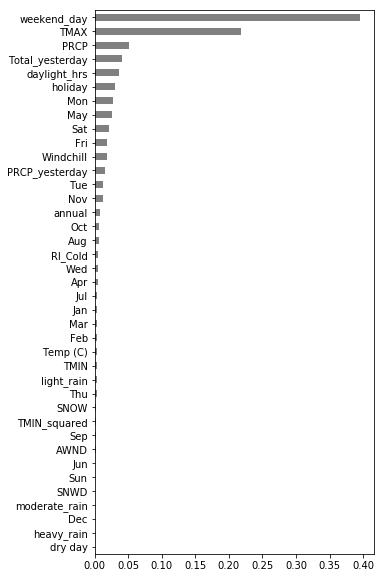

In [22]:
## plotting importance of features
plt.figure(figsize=(5,10)) ## to make it easier to see labels

importances = pd.Series(search.best_estimator_.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='gray')

### Take the last step

Yesterday's assingment said,

At the end of the day, take the last step in the "universal workflow of machine learning" — "You can train your final production model on all the available data (training and validation) and evaluate it one last time on the test set."

See the [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) documentation for the `refit` parameter, `best_estimator_` attribute, and `predict` method:

> **refit : boolean, or string, default=True**

> Refit an estimator using the best found parameters on the whole dataset.

> The refitted estimator is made available at the `best_estimator_` attribute and permits using `predict` directly on this `GridSearchCV` instance.

In [0]:
# TODO

## A few new things!
- Pipeline + RandomizedSearchCV
- SelectKBest for feature selection, in a pipeline
- Ridge Regression, a linear model with regularization

In [0]:
# TODO

In [0]:
# Shows which features were selected
selector = search.best_estimator_.named_steps['selectkbest']
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print('\n', 'Features not selected:')
for name in unselected_names:
    print(name)

## Regularization with Linear Models

- https://www.google.com/search?q=site%3Ascikit-learn.org+regularization+%22linear+models%22
  - https://scikit-learn.org/stable/modules/linear_model.html
  - https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression
  - https://scikit-learn.org/stable/modules/linear_model.html#lasso
  - https://scikit-learn.org/stable/modules/linear_model.html#setting-regularization-parameter
  - https://scikit-learn.org/stable/modules/linear_model.html#using-cross-validation
    
> The [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) is a linear model that estimates sparse coefficients. It is useful in some contexts due to its tendency to prefer solutions with fewer non-zero coefficients, effectively reducing the number of features upon which the given solution is dependent. 
  
> The `alpha` parameter controls the degree of sparsity of the estimated coefficients.
  
> scikit-learn exposes objects that set the Lasso `alpha` parameter by cross-validation: [`LassoCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV) ...

In [0]:
from ipywidgets import interact
from sklearn.exceptions import DataConversionWarning
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

def plot_lasso_coefs(power=-2):
    # Make pipeline with StandardScaler and Lasso Linear Model
    alpha = 10**power
    print(f'Lasso Alpha: {alpha}')
    pipe = make_pipeline(StandardScaler(), Lasso(alpha=alpha, max_iter=100000))
    
    # Get cross-validation scores
    maes = -cross_val_score(pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=3)
    print('Cross-Validated Mean Absolute Error:', maes.mean())
    
    # Get coefficients
    pipe.fit(X_train, y_train)
    coefficients = pd.Series(pipe.named_steps['lasso'].coef_, X_train.columns)
    
    # Plot coefficients
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-550,550)

interact(plot_lasso_coefs, power=(-2,2,1));

In [0]:
from sklearn.linear_model import LassoCV

pipe = make_pipeline(StandardScaler(), LassoCV(cv=3))
pipe.fit(X_train, y_train)
lasso = pipe.named_steps['lassocv']
print('Lasso Linear Model, alpha value optimized with cross validation:', lasso.alpha_)

In [0]:
alphas = lasso.alphas_
mses = lasso.mse_path_.mean(axis=1)
rmses = np.sqrt(mses)
plt.plot(alphas, rmses)
plt.title('Lasso Linear Model')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.xscale('log');

In [0]:
plt.plot(alphas, rmses)
plt.title('Lasso Linear Model')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.xlim(1,10)
plt.ylim(380,400);

## Want to learn more about regularized linear models?
- Aaron Gallant, [Ridge Regression](https://www.youtube.com/watch?v=XK5jkedy17w) (9 minute video)
- Selecting good features, [Part 2](https://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/) and [Part 4](https://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/)
- [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/), Chapters 3 & 6